In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Random Data Generator

## a. Univariate gaussian data generator

In [26]:
def sampleGaussian(mean, var):
    # Box–Muller method
    u, v = np.random.uniform(size=2)
    
    x = (-2 * np.log(u)) ** 0.5 * np.cos(2 * np.pi * v)
    # y = (-2 * np.log(u)) ** 0.5 * np.sin(2 * np.pi * v)
    
    return mean + x * var ** 0.5

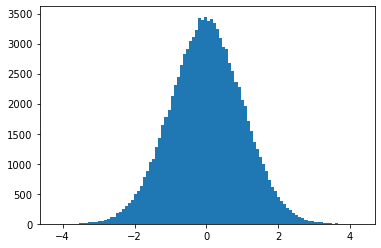

In [27]:
# test
samples = [sampleGaussian(0, 1) for _ in range(100000)]
plt.hist(samples, 100)
plt.show()

## b. Polynomial basis linear model data generator

In [28]:
def generatePolyDataPoint(n, a, w):
    # y = w^T phi(x) + e
    # w is a column vector of size nx1
    # phi transforms x into polynomial basis    
    # e ~ N(0, a)
    
    x = np.random.uniform(-1, 1)
    phi = np.array([x ** i for i in range(n)]).reshape(-1, 1)
    y = np.array(w, copy=False).reshape(-1) @ phi + sampleGaussian(0, a)
    
    return x, y.item()

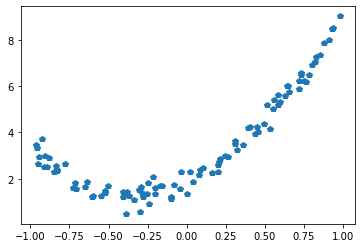

In [29]:
# test
p = [generatePolyDataPoint(3, 0.1, [2, 3, 4]) for _ in range(100)]
plt.plot(*zip(*p), 'p')
plt.show()

# 2. Sequential Estimator

In [30]:
def update(n, oldMean, oldM2, newValue):
    # Welford's online algorithm
    if n == 1:
        return newValue, 0
    n += 1
    newMean = oldMean + (newValue - oldMean) / n
    newM2 = oldM2 + (newValue - oldMean) * (newValue - newMean)
    return newMean, newM2

In [31]:
N = 1000
sourceMean, sourceVar = 3, 5

In [32]:
print(f'Data point source function: N({sourceMean}, {sourceVar})\n')

mean, M2 = 0, 0
for i in range(1, N + 1):
    dataPoint = sampleGaussian(sourceMean, sourceVar)
    mean, M2 = update(i, mean, M2, dataPoint)
    print(f'Add data point: {dataPoint}')
    print(f'Mean = {mean}\tVariance = {M2 / ((i if i > 1 else 2) - 1)}')

Data point source function: N(3, 5)

Add data point: 4.422085356300531
Mean = 4.422085356300531	Variance = 0.0
Add data point: 4.736366513106713
Mean = 4.526845741902592	Variance = 0.06584843034895457
Add data point: 0.00878681768622025
Mean = 3.397331010848499	Variance = 7.6877453811836745
Add data point: 3.705371260212629
Mean = 3.458939060721325	Variance = 5.150467266183334
Add data point: -0.1872539121363812
Mean = 2.8512402319117074	Variance = 6.632584448661858
Add data point: 6.915442644530713
Mean = 3.4318405765715654	Variance = 8.137680344770311
Add data point: 3.7190372637815936
Mean = 3.467740162472819	Variance = 6.7934289031421535
Add data point: 3.350521324804392
Mean = 3.454715847176327	Variance = 5.824683854236683
Add data point: 2.2578360637963617
Mean = 3.3350278688383304	Variance = 5.257757009241761
Add data point: 1.5901513226527384
Mean = 3.176402728276004	Variance = 4.981096549773339
Add data point: -2.7467362092762997
Mean = 2.682807816813312	Variance = 7.698981258

Add data point: 1.4654700560785452
Mean = 2.877439080676078	Variance = 5.109629949372922
Add data point: -1.890965584130739
Mean = 2.871302137735529	Variance = 5.132338065076964
Add data point: 7.427741018681613
Mean = 2.877158742980961	Variance = 5.1524438794414875
Add data point: 4.4673920741140964
Mean = 2.8792001208129676	Variance = 5.1490631225572345
Add data point: 3.23066917224102
Mean = 2.879650722160952	Variance = 5.1426033654867025
Add data point: 5.885843624537134
Mean = 2.8834998808067605	Variance = 5.147587988191978
Add data point: 3.0050098978536774
Mean = 2.8836552644602733	Variance = 5.141007421288619
Add data point: 2.5074181939650564
Mean = 2.8831747573459756	Variance = 5.134605841426055
Add data point: 7.036554033371873
Mean = 2.8884724349939677	Variance = 5.150071251022654
Add data point: 0.17221971788192914
Mean = 2.8850122404498757	Variance = 5.152904659463732
Add data point: 0.9707885922882733
Mean = 2.8825768414064132	Variance = 5.150999921730665
Add data point:

# 3. Baysian Linear regression

In [33]:
b = 100
n, a, w = 4, 1, [1, 2, 3, 4]
eps = 1e-7

In [34]:
points = {'x': [], 'y': []}
meanList = []
varList = []
mean = np.zeros((n, 1))
precision = b * np.eye(n)

# i = 0
while True:
    x, y = generatePolyDataPoint(n, a, w)
    points['x'].append(x)
    points['y'].append(y)
    
    # m: prior mean, s:prior precision
    # posterior precision = a^(-1)X^TX + s
    # posterior mean = postPrecision^(-1)(a^(-1)X^Ty + sm)
    
    X = np.array([x ** i for i in range(n)]).reshape(1, -1)
    postPrecision = 1 / a * X.T @ X + precision
    postMean = np.linalg.pinv(postPrecision) @ (1 / a * X.T * y + precision @ mean)
    
    if np.abs(np.mean(postMean) - np.mean(mean)) < eps:
        break
    
    mean, precision = postMean, postPrecision
    
    meanList.append(mean)
    varList.append(np.linalg.pinv(precision))
    
    print(f'Add data point ({x}, {y}):')
    
    print('\nPostirior mean:')
    for r in mean.reshape(-1):
        print(f'\t{r}')
    
    print('\nPosterior variance:')
    for r in np.linalg.pinv(precision):
        print('', *r, sep='\t')
    
    
    # P(Y) ~ N(X mean, a + X precision^(-1)X^T)
    
    Ymean = X @ mean
    Yvar = a + X @ np.linalg.pinv(precision) @ X.T
    
    print(f'\nPredictive distribution ~ N({Ymean.item()}, {Yvar.item()})')
    print('-' * 50)

Add data point (0.19242938325467462, 1.6035439101358784):

Postirior mean:
	0.015870630382735344
	0.003053975616412663
	0.0005876746443411039
	0.00011308586936496885

Posterior variance:
	0.00990102777802081	-1.904516363480126e-05	-3.6648490922291557e-06	-7.052246505391079e-07
	-1.9045163634800268e-05	0.009996335150907773	-7.052246505395483e-07	-1.3570594455915553e-07
	-3.664849092228963e-06	-7.052246505387347e-07	0.009999864294055444	-2.6113811215315965e-08
	-7.052246505390716e-07	-1.3570594455911186e-07	-2.6113811215359888e-08	0.009999994974935414

Predictive distribution ~ N(0.01648087186234476, 1.010277780208057)
--------------------------------------------------
Add data point (-0.8817851797104337, -1.3084302961841567):

Postirior mean:
	0.003125130888492861
	0.014409508479213757
	-0.00940300167771332
	0.00892703896991838

Posterior variance:
	0.009805431228490957	6.612605780277264e-05	-7.859907856588905e-05	6.540309103465231e-05
	6.612605780277126e-05	0.00992045231834902	6.605701

Add data point (0.9339127880006233, 8.519270514079167):

Postirior mean:
	0.6255540217330445
	0.5960658595168035
	0.24564558219231808
	0.36084907117765597

Posterior variance:
	0.006234285148293991	0.0001192966798764281	-0.0011013860858974727	0.0001320393508549132
	0.00011929667987642816	0.008439626143261868	0.0001796585025202336	-0.0008504971472977125
	-0.0011013860858974708	0.0001796585025202342	0.00922103413596288	0.00013447259581237205
	0.00013203935085491337	-0.0008504971472977102	0.0001344725958123721	0.009423071461282151

Predictive distribution ~ N(1.6904083668535592, 1.0245685266870446)
--------------------------------------------------
Add data point (-0.4297357597599738, -0.5800260834886742):

Postirior mean:
	0.6198300884227365
	0.5993327459539998
	0.24515307037699902
	0.36106526740896494

Posterior variance:
	0.006198921317389903	0.00013948028672241083	-0.001104428941851758	0.00013337506295210883
	0.00013948028672241026	0.008428106520672954	0.0001813951867736146	-0.0008512

	-0.0012811199154907852	7.051500927463415e-05	0.009037572391976612	4.2546149396581676e-05
	4.724537192827349e-05	-0.0010559590272913653	4.2546149396581324e-05	0.009278149484634686

Predictive distribution ~ N(1.0791591734172679, 1.0060163869998735)
--------------------------------------------------
Add data point (0.6055633780959044, 4.612243297807438):

Postirior mean:
	0.8583582833724693
	0.8277102374091185
	0.3981730472413059
	0.5214280628639086

Posterior variance:
	0.0056198221460007835	-3.895836903114482e-05	-0.0012918195755980573	3.963182225570755e-05
	-3.8958369031144986e-05	0.008039204196376258	6.089068243941679e-05	-0.0010628074028182827
	-0.0012918195755980578	6.089068243941444e-05	0.009033263633692565	3.948016927255894e-05
	3.963182225570766e-05	-0.0010628074028182816	3.9480169272559465e-05	0.009275967827298351

Predictive distribution ~ N(1.6213927112111632, 1.0090106285586222)
--------------------------------------------------
Add data point (-0.9904028886057341, -1.82413

	4.075645181767102e-08	-0.0017828252534192795	-1.3381409020364942e-05	0.008633338941404382

Predictive distribution ~ N(1.6491541430072585, 1.004745657330811)
--------------------------------------------------
Add data point (0.842544547741578, 6.8806155130642):

Postirior mean:
	1.1519367175199373
	1.3836715704108415
	0.6949795904421595
	0.9742041347743988

Posterior variance:
	0.004452689208148757	-0.00014676939761175165	-0.0017847378428722449	-1.111793778319292e-05
	-0.00014676939761175173	0.006919976581605377	-1.8713468901024703e-05	-0.0017996028791949878
	-0.001784737842872245	-1.871346890102328e-05	0.008295626238914345	-2.8250919913323168e-05
	-1.1117937783193203e-05	-0.001799602879194986	-2.8250919913321264e-05	0.008620160899822598

Predictive distribution ~ N(3.3937726339285708, 1.0119745307214032)
--------------------------------------------------
Add data point (-0.5498097674872733, -1.135612778096416):

Postirior mean:
	1.1456830392426445
	1.389396679407023
	0.69382464912267


Predictive distribution ~ N(0.041534259629187664, 1.0093830993808812)
--------------------------------------------------
Add data point (0.6542495181066872, 5.27279773991557):

Postirior mean:
	1.1693353858992268
	1.4488923528238313
	0.7457633641960777
	1.0242769381600971

Posterior variance:
	0.004254610229921814	-0.00011974621714419956	-0.0018236924315187296	1.1008763040061762e-05
	-0.00011974621714419976	0.00675659579581645	1.7098178101100377e-05	-0.0018951940600243156
	-0.00182369243151873	1.7098178101100485e-05	0.008183593055082952	-3.306662270446124e-06
	1.1008763040061737e-05	-0.0018951940600243139	-3.306662270445967e-06	0.008524973578949165

Predictive distribution ~ N(2.7233361013083557, 1.0069172510108984)
--------------------------------------------------
Add data point (0.6029070908090532, 4.948045182516445):

Postirior mean:
	1.1777691756221482
	1.4573807575346331
	0.7485426090989439
	1.026038137549482

Posterior variance:
	0.004242283253386194	-0.000132153019914073	-0.00

	4.153098775887111e-05	-0.0021671390649055534	2.221491897975553e-05	0.008279049372267418

Predictive distribution ~ N(3.689614018990217, 1.00863945671904)
--------------------------------------------------
Add data point (0.27530253426129714, 2.2842902904744915):

Postirior mean:
	1.2259644084304622
	1.645223195589735
	0.8305745943707555
	1.163259183316116

Posterior variance:
	0.0035759307334824342	-0.0001970821632569664	-0.0019095039744541106	4.281678709849465e-05
	-0.00019708216325696508	0.006184145835075471	6.889886121869673e-05	-0.0021665812335274525
	-0.00190950397445411	6.88988612186984e-05	0.007840405983763576	2.1721645924760802e-05
	4.281678709849416e-05	-0.002166581233527453	2.1721645924761714e-05	0.008278905005079802

Predictive distribution ~ N(1.7661210926742466, 1.0036751555784769)
--------------------------------------------------
Add data point (-0.9864387859095216, -1.654999714138535):

Postirior mean:
	1.2242170243099741
	1.6490992886510878
	0.8253162422888943
	1.1686

Add data point (0.3515987409317707, 4.231425830202139):

Postirior mean:
	1.223008586367743
	1.663477016050904
	0.8319063354962452
	1.1794504317205714

Posterior variance:
	0.003413256853628863	-0.0001359097892317455	-0.0019224523488268956	7.357033210371533e-05
	-0.00013590978923174487	0.0060318436643682785	0.00013954890336130368	-0.002245894438199312
	-0.0019224523488268956	0.00013954890336130514	0.007723928212453138	0.00010378863239046107
	7.357033210371558e-05	-0.0022458944381993145	0.00010378863239046054	0.00818990991120303

Predictive distribution ~ N(1.9619917436731624, 1.0036725475754793)
--------------------------------------------------
Add data point (0.20927803147707502, 3.8653032053451426):

Postirior mean:
	1.230400720332016
	1.6659668536159036
	0.8284266517191203
	1.1787409898210288

Posterior variance:
	0.0034023959493454927	-0.00013956798693288248	-0.0019173398180445255	7.461268071411527e-05
	-0.00013956798693288215	0.006030611500814355	0.00014127091912233923	-0.0022455

	-8.725328319670128e-05	0.0056346443781393855	0.00013045348212166084	-0.002428350659532457
	-0.0019466993493821765	0.0001304534821216614	0.007417322723174067	8.427577229182741e-05
	6.58471352343796e-05	-0.002428350659532458	8.427577229182667e-05	0.007966764941366954

Predictive distribution ~ N(2.9067979281077854, 1.004206266765701)
--------------------------------------------------
Add data point (-0.35117595473430296, -0.35846317316270093):

Postirior mean:
	1.2930573860148291
	1.8008682143573154
	0.907524321465708
	1.2982648758873816

Posterior variance:
	0.003016708890102998	-8.180224516119712e-05	-0.0019436681705569244	6.421024095757247e-05
	-8.180224516119819e-05	0.005630874909475906	0.00012835737977918025	-0.0024272187243594406
	-0.0019436681705569242	0.00012835737977917795	0.00741615713581351	8.49052116583595e-05
	6.421024095757293e-05	-0.002427218724359439	8.490521165835866e-05	0.007966425032125019

Predictive distribution ~ N(0.7163297448405199, 1.0033255004994504)
----------


Posterior variance:
	0.0029124314615876744	-0.00010251984234536468	-0.0019173758629751898	6.542358744312533e-05
	-0.00010251984234536376	0.005566154412369264	0.00012947252810409585	-0.0024627344191893476
	-0.001917375862975189	0.00012947252810409718	0.0073313816284838445	8.819761664185163e-05
	6.54235874431244e-05	-0.002462734419189348	8.819761664185377e-05	0.007915067725747009

Predictive distribution ~ N(4.935566312127493, 1.0120533683736908)
--------------------------------------------------
Add data point (0.8589348096083287, 8.365354201762694):

Postirior mean:
	1.2760014699310709
	1.8416830462623475
	0.9564925591058546
	1.3506016423235518

Posterior variance:
	0.0029103437667438985	-0.00010714238673232033	-0.00192263891797582	6.10634826212079e-05
	-0.0001071423867323199	0.005555919239986158	0.00011781914618196335	-0.002472388501600466
	-0.0019226389179758188	0.00011781914618196287	0.007318113526576037	7.720584188384576e-05
	6.106348262120797e-05	-0.0024723885016004676	7.72058418


Predictive distribution ~ N(0.8848756750898715, 1.0028103986751942)
--------------------------------------------------
Add data point (-0.07530755218435092, 1.4967200892335581):

Postirior mean:
	1.3255105576296962
	1.9041483664171361
	1.0373718734708406
	1.4051427535766183

Posterior variance:
	0.0026353074343039283	-0.0001288811274647555	-0.0018946933208744898	5.193761605201431e-05
	-0.00012888112746475632	0.005291928917237164	8.658316273859833e-05	-0.0025719488066730505
	-0.0018946933208744915	8.658316273859779e-05	0.007101335336916324	3.346504608613489e-05
	5.1937616052014754e-05	-0.0025719488066730497	3.3465046086134535e-05	0.007796365963101959

Predictive distribution ~ N(1.1873968598126303, 1.0026631860337578)
--------------------------------------------------
Add data point (0.5868001436413941, 4.207402470091817):

Postirior mean:
	1.3276572553312762
	1.9069317580306118
	1.0380525755801582
	1.4052877565371633

Posterior variance:
	0.0026316428454478333	-0.00013363260499295426	

	0.002562427488705941	-0.00013788646231860846	-0.0018900399831531572	4.7371985549747184e-05
	-0.00013788646231860697	0.005209871524345626	7.28654457373888e-05	-0.0025901234472983713
	-0.0018900399831531568	7.28654457373914e-05	0.007054958765608256	2.4688826288430993e-05
	4.7371985549746154e-05	-0.002590123447298374	2.468882628843339e-05	0.007775213278918115

Predictive distribution ~ N(0.6317178188401513, 1.0030008206912562)
--------------------------------------------------
Add data point (0.3627510946631538, 2.315026010773013):

Postirior mean:
	1.3543023479838125
	1.9378040891861115
	1.06462168951864
	1.4208382605102352

Posterior variance:
	0.0025573067902247074	-0.0001415879604095946	-0.0018879291203126084	4.854214692485247e-05
	-0.00014158796040959507	0.005207195895587604	7.439128343380518e-05	-0.0025892775958755677
	-0.001887929120312607	7.439128343380269e-05	0.007054088622219046	2.420646042111685e-05
	4.854214692485265e-05	-0.002589277595875567	2.4206460421116467e-05	0.00777494


Predictive distribution ~ N(1.8142920176953536, 1.002354336327719)
--------------------------------------------------
Add data point (0.28699054118654255, 1.6031112915864507):

Postirior mean:
	1.375390607396146
	2.0343282606746715
	1.1369189189731561
	1.4859598481747378

Posterior variance:
	0.002362913117808934	-0.00015826796555879863	-0.001886438088718005	4.4101219962529714e-05
	-0.00015826796555880494	0.004951489409580567	4.681800541556501e-05	-0.0026824831192604334
	-0.0018864380887180046	4.681800541554644e-05	0.0068412974947991536	-1.3878388782842283e-05
	4.410121996252574e-05	-0.0026824831192604356	-1.387838878283158e-05	0.007654136195846668

Predictive distribution ~ N(2.087988751271269, 1.0023876809770367)
--------------------------------------------------
Add data point (0.9208939970185801, 8.46568671024162):

Postirior mean:
	1.3773883772934474
	2.041519514915625
	1.149017859957354
	1.4968084724304236

Posterior variance:
	0.0023624920059691543	-0.00015978381696281815	-0.00

	1.5570567029406444

Posterior variance:
	0.0023087229714784407	-0.00014646532356958413	-0.0018827077628493026	3.309160303839428e-05
	-0.00014646532356958768	0.004877555069045692	6.380163832611834e-06	-0.002734246610144962
	-0.0018827077628493	6.380163832599615e-06	0.006720811978765741	-8.105991467425148e-05
	3.309160303839134e-05	-0.0027342466101449633	-8.105991467424407e-05	0.00757489342783664

Predictive distribution ~ N(-0.22869779884036268, 1.0052143838233059)
--------------------------------------------------
Add data point (-0.5952011676028639, -0.8846166107449818):

Postirior mean:
	1.3727529207333842
	2.0978981798327423
	1.2132235417382031
	1.557018323370989

Posterior variance:
	0.0023057678244720417	-0.00014222502971360053	-0.0018835856368410392	3.303227461569032e-05
	-0.0001422250297136051	0.004871470738233672	7.639811384979349e-06	-0.0027341614807264475
	-0.001883585636841038	7.639811384966533e-06	0.006720551192164018	-8.107753913731641e-05
	3.303227461568688e-05	-0.002734

	-0.0018539319120634157	3.9344084179999974e-05	0.006510163839249194	-4.146960239573462e-05
	3.932273285182183e-05	-0.0028046198763386643	-4.146960239572727e-05	0.007458757045214145

Predictive distribution ~ N(0.949845794396275, 1.0022393649219032)
--------------------------------------------------
Add data point (0.9802082144763653, 9.483754103811457):

Postirior mean:
	1.3783632122230138
	2.1784868668852004
	1.2575428505212476
	1.6389762313988112

Posterior variance:
	0.0021479366149583256	-0.00010402344462126343	-0.0018552488465593128	3.804339510543794e-05
	-0.0001040234446212672	0.004679469343470621	3.1141903786946174e-05	-0.002812587895258511
	-0.0018552488465593128	3.114190378693668e-05	0.006490997967979266	-6.0088313223313e-05
	3.8043395105435756e-05	-0.002812587895258514	-6.0088313223306705e-05	0.007440669874117204

Predictive distribution ~ N(6.265566106452657, 1.0102955272535776)
--------------------------------------------------
Add data point (0.2110611771874884, 2.31838933


Predictive distribution ~ N(2.4347377602704956, 1.0022018968139512)
--------------------------------------------------
Add data point (0.7258372769757206, 4.590109456770568):

Postirior mean:
	1.3801328977225555
	2.190293988057208
	1.2724581349034163
	1.6490350588508753

Posterior variance:
	0.002110855373258104	-0.000109185502525605	-0.001842898760937854	3.84551956721292e-05
	-0.00010918550252560791	0.004641866418364049	2.4570679783029035e-05	-0.0028178227788531606
	-0.001842898760937854	2.4570679783020215e-05	0.006457272631550494	-7.77959902082981e-05
	3.845519567212782e-05	-0.0028178227788531614	-7.779599020829494e-05	0.007425450394508774

Predictive distribution ~ N(4.270902344323854, 1.0037867770899322)
--------------------------------------------------
Add data point (0.8801847808823575, 6.923237202167377):

Postirior mean:
	1.381049729282381
	2.193394883155823
	1.2771351651298057
	1.6528645516361884

Posterior variance:
	0.002110481785858198	-0.00011044904469413067	-0.001844804

	0.0019499800672337791	-7.830881899432625e-05	-0.0017951280609428857	3.342341032563696e-05
	-7.830881899432898e-05	0.004455323122801352	2.8767249188761135e-05	-0.0028727170628973587
	-0.001795128060942887	2.8767249188755944e-05	0.006244043666038994	-5.012704356879736e-05
	3.34234103256359e-05	-0.0028727170628973582	-5.012704356879287e-05	0.007327010053298865

Predictive distribution ~ N(-0.73064500801391, 1.0063665338126864)
--------------------------------------------------
Add data point (0.890749005925852, 6.744554497049266):

Postirior mean:
	1.3881500822131763
	2.2479774474523992
	1.295994281132693
	1.693218067866351

Posterior variance:
	0.00194975160058526	-7.920585011294176e-05	-0.0017966285010165958	3.2178414060315876e-05
	-7.920585011294388e-05	0.004451801099639669	2.287605480023995e-05	-0.0028776053054473433
	-0.0017966285010165943	2.2876054800233083e-05	0.0062341896220051716	-5.830347676024687e-05
	3.217841406031383e-05	-0.002877605305447345	-5.8303476760242295e-05	0.007320

Add data point (0.09918307828076767, 1.476246861840054):

Postirior mean:
	1.3831683600204687
	2.254660436352418
	1.2979126919317143
	1.697298330151642

Posterior variance:
	0.0019058626986796236	-7.565464085523303e-05	-0.0017790140701828385	3.474414247951588e-05
	-7.565464085523489e-05	0.004405960127549266	3.120949558493102e-05	-0.002875200367437445
	-0.0017790140701828363	3.120949558492387e-05	0.00620518319315637	-5.568544787876225e-05
	3.474414247951403e-05	-0.0028752003674374456	-5.5685447878757715e-05	0.007313232775042631

Predictive distribution ~ N(1.621216497479952, 1.001899375329489)
--------------------------------------------------
Add data point (-0.12840402385439886, 0.7662233716845371):

Postirior mean:
	1.3825184314468062
	2.2548791715150798
	1.2984917837888958
	1.6971647965838628

Posterior variance:
	0.0019023119399238168	-7.44596237018084e-05	-0.001775850314093891	3.401460772106986e-05
	-7.445962370181059e-05	0.004405557941398304	3.0144725192021757e-05	-0.002874954840


Predictive distribution ~ N(4.9922839806793675, 1.0040414126787456)
--------------------------------------------------
Add data point (0.08711690514774073, -0.4573647699371617):

Postirior mean:
	1.3891493335663478
	2.3057253564852496
	1.3894970319630335
	1.7771495159321322

Posterior variance:
	0.0018005831807765874	-5.378758065417754e-05	-0.0017543613561977897	2.653545883790416e-05
	-5.37875806541795e-05	0.0042487234951446365	6.370147406676377e-06	-0.0029164910544807977
	-0.0017543613561977903	6.370147406671586e-06	0.006023161140413349	-0.00010375456044676098
	2.653545883790399e-05	-0.0029164910544807964	-0.00010375456044676034	0.007209231275980559

Predictive distribution ~ N(1.601737359405781, 1.0017968842703844)
--------------------------------------------------
Add data point (-0.7275270060656984, -0.9486029491690615):

Postirior mean:
	1.388510604794463
	2.307156350199505
	1.3884555578258135
	1.7776335055758423

Posterior variance:
	0.0017997742798291664	-5.197533698805812e-05	

	0.0017680229643283944	-4.2595667983472065e-05	-0.0017461384079690639	2.291707379747643e-05
	-4.2595667983472167e-05	0.0041993270015132644	8.246910532255609e-06	-0.0029206417639489105
	-0.0017461384079690643	8.246910532256286e-06	0.005983114798507293	-8.599598153525138e-05
	2.2917073797475435e-05	-0.00292064176394891	-8.59959815352476e-05	0.007189720122046831

Predictive distribution ~ N(4.9589479625566675, 1.0039172368264322)
--------------------------------------------------
Add data point (-0.9820069842235115, -3.3885713083546705):

Postirior mean:
	1.3907333383261697
	2.3140183743306117
	1.3787033517572231
	1.7921425072797033

Posterior variance:
	0.0017680121886554394	-4.24517686991128e-05	-0.0017465617497737567	2.3330448809037706e-05
	-4.245176869912318e-05	0.004197405357814791	1.3900254223066005e-05	-0.0029261620102079594
	-0.0017465617497737565	1.3900254223037386e-05	0.00596648304991004	-6.975579643470872e-05
	2.3330448809054464e-05	-0.0029261620102079594	-6.975579643475467e-05


Predictive distribution ~ N(6.174077066236082, 1.0065656752509529)
--------------------------------------------------
Add data point (0.8182427640491166, 5.435608366692714):

Postirior mean:
	1.3728995405174593
	2.336926393665805
	1.4001055738144532
	1.842611073476168

Posterior variance:
	0.0016748128408065912	-3.4994345978093665e-05	-0.0017060608389580765	2.646950186732936e-05
	-3.499434597809582e-05	0.004082821493707406	3.628477285798152e-05	-0.002957878677990387
	-0.0017060608389580757	3.628477285797714e-05	0.00579422966212412	-3.399947268035561e-05
	2.646950186733281e-05	-0.002957878677990388	-3.3999472680363896e-05	0.007087089465267687

Predictive distribution ~ N(5.231912317848184, 1.0041829015237382)
--------------------------------------------------
Add data point (-0.4183358220024169, -1.113569087063596):

Postirior mean:
	1.370655019345755
	2.33938283684492
	1.4012444142276088
	1.8414167691476817

Posterior variance:
	0.0016728872287796225	-3.2886922537896623e-05	-0.0017050


Predictive distribution ~ N(5.561134102903313, 1.0045874333777436)
--------------------------------------------------
Add data point (-0.08628543045651327, 0.18997381324033968):

Postirior mean:
	1.377351180188016
	2.3609251027404614
	1.431289411967998
	1.8673168272824179

Posterior variance:
	0.0016518045665194782	-3.5171307018891836e-05	-0.0017017709962283618	2.3188954981743483e-05
	-3.517130701889552e-05	0.004039451713635826	1.6936519915284936e-05	-0.002969495939670704
	-0.0017017709962283618	1.6936519915275293e-05	0.0057379032889598456	-6.673003720226318e-05
	2.3188954981748498e-05	-0.0029694959396707045	-6.673003720227709e-05	0.00705233624351768

Predictive distribution ~ N(1.1830943589716112, 1.0016625494169926)
--------------------------------------------------
Add data point (0.9029789415714058, 8.894423030611847):

Postirior mean:
	1.3780566444935105
	2.3649955726543412
	1.4396090584862389
	1.874327139078729

Posterior variance:
	0.0016517426518120454	-3.552854969137214e-05	-

Add data point (0.05145847699703454, 2.02432076593361):

Postirior mean:
	1.3696298205653306
	2.3832255285389836
	1.4412115216036647
	1.8959785676774148

Posterior variance:
	0.0015667334320550864	-3.620505159986041e-05	-0.0016550324658968518	2.7763990355351304e-05
	-3.6205051599861756e-05	0.003942623268564193	3.745325065192405e-05	-0.002990284914887001
	-0.0016550324658968524	3.7453250651920174e-05	0.005575223464215364	-3.4395103889591684e-05
	2.776399035535405e-05	-0.0029902849148870014	-3.439510388959958e-05	0.006969874733168863

Predictive distribution ~ N(1.496341615941734, 1.0015646973524892)
--------------------------------------------------
Add data point (0.21847769801844086, 0.9880427076048087):

Postirior mean:
	1.3681655906112802
	2.3824382947699014
	1.4425777892151275
	1.8965271199901412

Posterior variance:
	0.0015645461550819564	-3.738102692451237e-05	-0.001652991525758028	2.8583421646768733e-05
	-3.738102692451485e-05	0.003941991013033144	3.855054892362704e-05	-0.002989

	-0.0016401946468588729	4.511139120783193e-05	0.005548453025274142	-3.25428692466718e-05
	3.0355489784430905e-05	-0.0029854938516114425	-3.254286924668221e-05	0.006961521430608708

Predictive distribution ~ N(-0.7729363283720541, 1.0043105645797028)
--------------------------------------------------
Add data point (-0.5940669914420154, 2.3075116504321853):

Postirior mean:
	1.3635956648242975
	2.3954960480379817
	1.4544378423497109
	1.896303679014908

Posterior variance:
	0.0015377944624502778	-3.49037611985908e-05	-0.0016404846500061828	3.003145281299373e-05
	-3.490376119859221e-05	0.0039059598936087036	4.562192342624304e-05	-0.0029849234049959274
	-0.0016404846500061834	4.5621923426239767e-05	0.005548364422325342	-3.264187034874988e-05
	3.0031452812996982e-05	-0.002984923404995928	-3.264187034875845e-05	0.006961410811059981

Predictive distribution ~ N(0.0562338226560013, 1.0020264382483897)
--------------------------------------------------
Add data point (0.3273016309822776, 2.1557


Posterior variance:
	0.0014718060839078156	-3.785544796400954e-05	-0.0016145159262109102	2.9781487646539578e-05
	-3.785544796400962e-05	0.0037948646723540047	4.851345641515857e-05	-0.003013070399723172
	-0.00161451592621091	4.85134564151581e-05	0.005369540781293493	-8.859727066142236e-06
	2.978148764654024e-05	-0.003013070399723174	-8.859727066144279e-06	0.006855494096562525

Predictive distribution ~ N(3.327312410248225, 1.001704131194827)
--------------------------------------------------
Add data point (0.8941902652656757, 6.988203992810432):

Postirior mean:
	1.3607565256248582
	2.413321731901266
	1.5163304536742306
	1.9473772081399883

Posterior variance:
	0.0014717778942711006	-3.806311828800434e-05	-0.0016149707719356893	2.9408027303638646e-05
	-3.80631182880052e-05	0.0037933347851865163	4.516265200490191e-05	-0.0030158216459059456
	-0.0016149707719356893	4.516265200490024e-05	0.0053622017497398	-1.4885588344573586e-05
	2.9408027303639286e-05	-0.003015821645905947	-1.4885588344


Predictive distribution ~ N(4.653067578854284, 1.0025367414908262)
--------------------------------------------------
Add data point (0.9842660107026744, 9.09830350688976):

Postirior mean:
	1.3551500078041678
	2.4263669940287125
	1.5387723108368396
	1.957125868786127

Posterior variance:
	0.0014539292525317204	-3.757433546160018e-05	-0.001601950821839228	2.8579613020100277e-05
	-3.757433546160132e-05	0.003776105893948807	3.661950175028388e-05	-0.0030186795129863338
	-0.0016019508218392284	3.661950175028116e-05	0.005325011917860718	-3.4363948653813906e-05
	2.8579613020102086e-05	-0.003018679512986332	-3.436394865381846e-05	0.006832305592911838

Predictive distribution ~ N(7.100263324416757, 1.0075387457907279)
--------------------------------------------------
Add data point (-0.9974203511767223, -2.78215272011774):

Postirior mean:
	1.3553192737402437
	2.4273673494010017
	1.5339874831100002
	1.9620157485883913

Posterior variance:
	0.0014539123198567365	-3.767440693953112e-05	-0.0016

	-0.0015694495860976167	3.1100642667116136e-05	0.005163808183223914	-1.9472182047967242e-05
	2.255762716061305e-05	-0.0030281827663472603	-1.9472182047967934e-05	0.006719269870184365

Predictive distribution ~ N(1.238073119726715, 1.0013991041602266)
--------------------------------------------------
Add data point (0.96626094985377, 8.424055257881673):

Postirior mean:
	1.3637380720767212
	2.461515908444374
	1.570618810115287
	2.0084893746567882

Posterior variance:
	0.001394536321585176	-2.8990206711242675e-05	-0.0015691949752026978	2.2802561322648162e-05
	-2.899020671124343e-05	0.003683122331493216	2.841686504952208e-05	-0.0030307645444053732
	-0.0015691949752026976	2.841686504951927e-05	0.005153222563391808	-2.96554851781583e-05
	2.2802561322648576e-05	-0.0030307645444053745	-2.9655485178160197e-05	0.006709473593321402

Predictive distribution ~ N(7.0206066781942855, 1.0065585590070825)
--------------------------------------------------
Add data point (0.1769029335192327, 1.6547090

	-0.0015586118741937826	2.700143513681126e-05	0.0050991579348479595	-4.466909819388306e-05
	2.2510504848019204e-05	-0.003036420246477617	-4.466909819388503e-05	0.006673152565929227

Predictive distribution ~ N(6.552989985453875, 1.0051343765159118)
--------------------------------------------------
Add data point (-0.9525568674602167, -2.7944849425332876):

Postirior mean:
	1.3659721018008693
	2.4700299921733673
	1.5902766343704862
	2.0292089154892814

Posterior variance:
	0.001378197143651959	-2.465191208354848e-05	-0.0015585137812059121	2.2418387676717654e-05
	-2.4651912083548534e-05	0.0036592001573804507	2.9641242747575906e-05	-0.0030388992372307852
	-0.001558513781205912	2.9641242747576255e-05	0.005089722354947596	-3.580833302735702e-05
	2.2418387676718033e-05	-0.0030388992372307857	-3.580833302735724e-05	0.006664831597831303

Predictive distribution ~ N(-1.2977897091270538, 1.0060487043552147)
--------------------------------------------------
Add data point (0.7866994760107111, 8

## plot

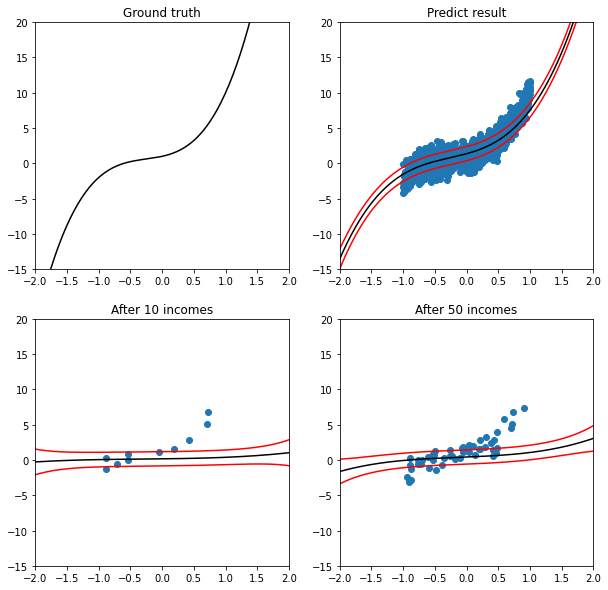

In [35]:
plt.figure(figsize=(10, 10))

gt = plt.subplot(2, 2, 1)
final = plt.subplot(2, 2, 2)
after10 = plt.subplot(2, 2, 3)
after50 = plt.subplot(2, 2, 4)

gt.set_title('Ground truth')
final.set_title('Predict result')
after10.set_title('After 10 incomes')
after50.set_title('After 50 incomes')

gt.set_xlim(-2, 2)
after10.set_xlim(-2, 2)
after50.set_xlim(-2, 2)
final.set_xlim(-2, 2)

gt.set_ylim(-15, 20)
after10.set_ylim(-15, 20)
after50.set_ylim(-15, 20)
final.set_ylim(-15, 20)



# plot data points
after10.plot(points['x'][:10], points['y'][:10], 'o')
after50.plot(points['x'][:50], points['y'][:50], 'o')
final.plot(points['x'], points['y'], 'o')


p = np.linspace(-2, 2, 200)

# plot ground truth
y = []
for x in p:
    X = np.array([x ** i for i in range(n)]).reshape(1, -1)
    y.append((X @ w).item())
gt.plot(p, y, 'k-')


# plot predictive distribution
for i, axes in zip([9, 49, -1], [after10, after50, final]):
    yUpper = []
    yMean = []
    yLower = []
    for x in p:
        X = np.array([x ** i for i in range(n)]).reshape(1, -1)
        mean = X @ meanList[i]
        var = a + X @ varList[i] @ X.T
        yUpper.append((mean + var).item())
        yMean.append(mean.item())
        yLower.append((mean - var).item())
    axes.plot(p, yUpper, 'r-')
    axes.plot(p, yMean, 'k-')
    axes.plot(p, yLower, 'r-')

    
plt.show()